# Análisis de Supervivencia (Parte 1)

### Tabla de contenido:
- Conceptos básicos del análisis de supervivencia
- Teoría del ajustador de Kaplan-Meier con un ejemplo.
- Teoría del ajustador de Nelson-Aalen con un ejemplo.
- Instalador Kaplan-Meier basado en diferentes grupos.
- Prueba de rango logarítmico.
- Regresión de Cox.

### Instalación de librerías mendiantes pip install o conda install


- pip install lifelines
- pip install panda
- pip install numpy
- pip install matplotlib

In [ ]:
#Importamos las librerías Necesarias para trabajar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

### Descargamos los datos

In [ ]:
# !wget https://raw.githubusercontent.com/towardsai/tutorials/master/survival_analysis_in_python/lung.csv

### Lectura del dataset:

In [ ]:
data = pd.read_csv("lung.csv")
data.head()

### Descripción de los datos
- Inst: Código de la Institución
- Time: Tiempo de supervivencia del paciente
- Status: Estado de censura de los datos; 1=Censurado (Vivo); 2=Muerto
- Age: Edad del paciente en años
- Sex: Seco del paciente; Hombre=1; Mujer=2
- Ph.ecog: Ecog performance score; 0=bueno; 5=muerto;
- Ph.Karno: KArnosky performance score rated by phisician; 0=Malo; 100=Bueno;
- Meal.cal: Calorías consumidas por el paciente
- Wt.loss: Peso perdido por el paciente

##### Escala ECOG
La escala ECOG es una forma práctica de medir la calidad de vida de un paciente exclusivamente con cáncer u oncológico, cuyas expectativas de vida cambian en el transcurso de meses, semanas e incluso días. 

La escala ECOG valora la evolución de las capacidades del paciente en su vida diaria manteniendo al máximo su autonomía. Este dato es muy importante cuando se plantea un tratamiento, ya que de esta escala dependerá el protocolo terapéutico y el pronóstico de la enfermedad.


https://es.wikipedia.org/wiki/Escala_ECOG

##### Escala Karnofsky
La Escala Karnofsky, también llamada, KPS, es la forma típica de medir la capacidad de los pacientes con cáncer de realizar tareas rutinarias. Los puntajes de la escala de rendimiento de Karnofsky oscilan entre 0 y 100. Un puntaje más alto significa que el paciente tiene mejor capacidad de realizar las actividades cotidianas. La KPS se puede usar para determinar el pronóstico del paciente, medir los cambios en la capacidad del paciente para funcionar o decidir si un paciente puede ser incluido en un estudio clínico. 

https://es.wikipedia.org/wiki/Escala_Karnofsky


#####  Imprima las columnas en nuestro conjunto de datos:

In [ ]:
#Print the column names of our data:
print(data.columns)

##### Limpieza de los datos

Necesitamos eliminar las columnas que no ofrecen información a nuestro modelo de predicción

In [ ]:
data.drop(columns=['Unnamed: 0'])
# Si queremos eliminar varias columnas:
# data.drop(columns=['Unnamed: 0','sex'])
data.head()

##### Obtenga información adicional sobre el conjunto de datos:

Nos da información sobre el tipo de datos de las columnas junto con su contador de valor nulo. Necesitamos eliminar las filas con un valor nulo para algunos de los métodos de análisis de supervivencia.

In [ ]:
#Additional info about our dataset:
data.info()

##### Obtenga información estadística sobre el conjunto de datos:

Nos da alguna información estadística como el número total de filas, media, desviación estándar, valor mínimo, percentil 25, percentil 50, percentil 75 y valor máximo para cada columna.

In [ ]:
#Statistical info about our dataset:
data.describe()

##### Distribución de los datos mediante histograma

In [ ]:
#Plot histogram for sex of patient:
print(data["sex"].hist())

Esto nos da una idea general sobre cómo se distribuyen nuestros datos. En el siguiente gráfico, podemos ver que alrededor de 139 valores tienen un estado de 1, y aproximadamente 90 valores tienen un estado de 2, lo que significa que hay 139 hombres y alrededor de 90 mujeres en nuestro conjunto de datos.

In [ ]:
print(data["age"].hist())

In [ ]:
print(data["status"].hist())

In [ ]:
print(data["ph.ecog"].hist())

In [ ]:
print(data["ph.karno"].hist())

##### Organización de los datos

Ahora necesitamos organizar nuestros datos. Agregaremos una nueva columna en nuestro conjunto de datos que se llama "muerto". Almacena los datos sobre si una persona que es parte de nuestro experimento está viva o muerta (según el valor de estado). Si nuestro valor de estado es 1, entonces esa persona está viva, y si nuestro valor de estado es 2, entonces la persona está muerta. Es un paso crucial para lo que debemos hacer en el siguiente paso, ya que vamos a almacenar nuestros datos en columnas denominadas censuradas y observadas. Donde los datos observados almacenan el valor de las personas muertas en una línea de tiempo específica, y los datos censurados almacenan el valor de las personas vivas o personas que no vamos a investigar.

In [ ]:
#Organize our data:

#If status = 1 , then dead = 0
#If status = 2 , then dead = 1

data.loc[data.status == 1, 'dead'] = 0
data.loc[data.status == 2, 'dead'] = 1

data.head()

## Cálculo de la curva de supervivencia (Método Kaplan Meier)

Aquí nuestro objetivo es encontrar el número de días que sobrevivió un paciente antes de morir. Nuestro evento de interés será "muerte", que se almacena en la columna "muertos". El primer argumento que se necesita es la línea de tiempo de nuestro experimento.

In [ ]:
#Create an object of KaplanMeierFitter:
kmf = KaplanMeierFitter() 
#Fit the parameter values in our object:
kmf.fit(durations =  data["time"], event_observed = data["dead"])

####  Generar tabla de eventos:

Uno de los métodos más importantes del objeto kmf es "event_table". Nos da diversa información para nuestro análisis de supervivencia. Echemos un vistazo columna por columna.

In [ ]:
#Print the event table:

kmf.event_table

# Removed = Observed + Censored
# Censored = Person that didn't die.(They are of no use to us!)
# Observed = Persons that died.

In [ ]:
# Visualizamos las primeras 5 filas de nuestra tabla de eventos
events_table = kmf.event_table
# df.iloc[filas:columnas]
print(events_table.iloc[:5,:])

a) event_at: Almacena el valor de la línea de tiempo para nuestro conjunto de datos. es decir, cuándo se observó al paciente en nuestro experimento o cuándo se realizó el experimento. Pueden ser varios minutos, días, meses, años y otros. En nuestro caso, será por muchos días. Almacena el valor de los días de supervivencia de los sujetos.

b) at_risk: Almacena el número de pacientes actuales bajo observación. Al principio, será el número total de pacientes que vamos a observar en nuestro experimento. Si se agregan nuevos pacientes en un momento determinado, tenemos que aumentar su valor en consecuencia. Por lo tanto:



c) entrada: almacena el valor de los nuevos pacientes en una línea de tiempo determinada. Es posible que durante la experimentación, otros pacientes también sean diagnosticados con la enfermedad. Para dar cuenta de eso, tenemos la columna de entrada.

d) censurado: Nuestro objetivo final es encontrar la probabilidad de supervivencia de un paciente. Al final del experimento, si la persona aún está viva, la agregaremos a la categoría censurada. Ya hemos discutido los tipos de censura.

e) observado: Almacena el valor del número de sujetos que murieron durante el experimento. Desde una perspectiva amplia, estas son las personas que conocieron nuestro evento de interés.

f) eliminado: Almacena los valores de los pacientes que ya no forman parte de nuestro experimento. Si una persona muere o es censurada, entra en esta categoría. En resumen, es una adición de los datos en la categoría de observados y censurados.



### Cálculo de la probabilidad de supervivencia para líneas de tiempo individuales:

Veamos primero la fórmula para calcular la supervivencia de una persona en particular en un momento dado.

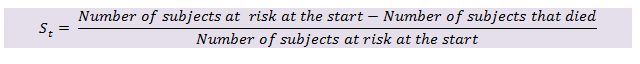

In [ ]:
print(events_table.iloc[:5,:])

##### a) Probabilidad de supervivencia en t = 0 únicamente:

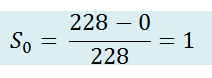

In [ ]:
#Calculamos la probabilidad de suvervivencia en un instante de tiempo t:

# Indicamos que queremos coger la primera fila t = 0  y todas las columnas
event_at_0 = kmf.event_table.iloc[0,:]  

#Calculamos la probabilidad de suvervivencia en un instante de tiempo t=0:

#Accedemos a las columnas del dataframe con dataframe.columna
surv_for_0 = (event_at_0.at_risk - event_at_0.observed)/event_at_0.at_risk

# La probabilidad de supervivencia en el instante t=0 será del 100%
print(surv_for_0)

In [ ]:
print(events_table.iloc[:5,:])

##### b) Probabilidad de supervivencia en t = 5:

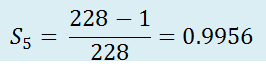

In [ ]:
#Calculating the survival probability for a given time:

event_at_5 = kmf.event_table.iloc[1,:]

#Calculate the survival probability for t=5:
surv_for_5 = (event_at_5.at_risk - event_at_5.observed)/event_at_5.at_risk
surv_for_5

## ¿Podríais calcular la probabilidad de supervivencia de un paciente en t = 11?


In [ ]:
print(events_table.iloc[:5,:])

Ahora, lo que encontramos aquí es la probabilidad para un tiempo específico. Lo que queremos es la probabilidad de todo el tiempo para un paciente. es decir, la probabilidad de que el paciente sobreviva a todas las rondas del experimento.

En pocas palabras, queremos encontrar la probabilidad de que una persona sobreviva todo el tiempo que vivió después del diagnóstico. Lo que acabamos de encontrar es la probabilidad de un experimento en particular solamente.

## Ejemplo de probabilidad

Tomemos un ejemplo sencillo para comprender el concepto de probabilidad condicional. Por ejemplo, tenemos un total de 15 bolas en una caja no transparente. De las 15 bolas, somos siete bolas negras, cinco bolas rojas y tres bolas verdes. Aquí hay una vista pictórica para eso.

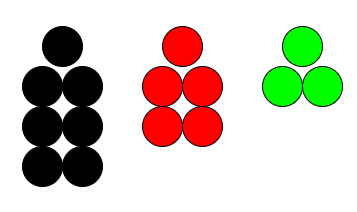

a) Probabilidad de elegir una bola roja:

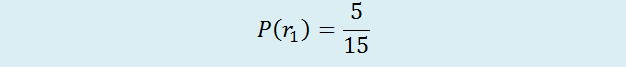

b) Probabilidad de elegir la segunda bola roja:
Como quitamos una bola que era roja, el número total de bolas rojas que tenemos es 4 y el número total de bolas que tenemos es 14.

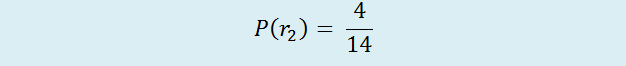

Si nuestra pregunta es encontrar la probabilidad de que ambas bolas sean rojas, la multiplicaremos, y eso es precisamente lo que vamos a hacer en el análisis de supervivencia. Sabemos que un paciente ha sobrevivido al primer intervalo de tiempo y queremos encontrar la probabilidad de que sobreviva al segundo intervalo de tiempo dado que ha sobrevivido al primer intervalo de tiempo. Mi punto aquí es que no queremos encontrar la probabilidad del segundo intervalo de tiempo solamente. Queremos la probabilidad total de que sobreviva todo el período.

En nuestro ejemplo, la probabilidad de que ambas bolas sean rojas es la siguiente:

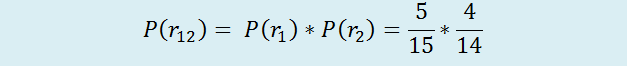

En el análisis de supervivencia, podemos escribir la fórmula de la siguiente manera:

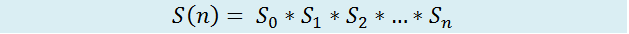

## Encontrar la probabilidad de supervivencia

Queremos encontrar la probabilidad de que un paciente haya sobrevivido durante toda la línea de tiempo hasta ahora. Ahora necesitamos encontrar la probabilidad de supervivencia real de un paciente.

##### a) Probabilidad de supervivencia para t = 0:



In [ ]:
#Calculating the actual survival probability at a given time:

surv_after_0 = surv_for_0 
print("Survival Probability After 0 Days: ",surv_after_0)

##### b) Probabilidad de supervivencia para t = 5:

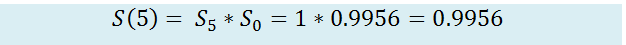

In [ ]:
#Calculating the actual survival probability at a given time:

surv_after_5 = surv_for_0 * surv_for_5
print("Survival Probability After 5 Days: ",surv_after_5)

## ¿Podríais clacular la Probabilidad de supervivencia de un paciente durante toda la línea de tiempo hasta llegar al instante t = 11?

## Predecir la probabilidad con el Método Kaplan Meier:
Ahora, la función de predicción del objeto kmf hace todo este trabajo por nosotros. Sin embargo, siempre es una buena práctica conocer la lógica detrás de esto.

In [ ]:
#Get the probability values the easy way!

print("Survival probability for t=0: ",kmf.predict(0))
print("Survival probability for t=5: ",kmf.predict(5))
print("Survival probability for t=11: ",kmf.predict(11))

##### Encontrar la probabilidad de supervivencia para una matriz de la línea de tiempo:

In [ ]:
kmf.predict([0,5,11,12])

### Obtenga la probabilidad de supervivencia para toda la línea de tiempo:

In [ ]:
#To get the full list:
kmf.survival_function_

La probabilidad de supervivencia de un paciente en la línea de tiempo 0 es 1. Al captar nuestros pensamientos, deducimos que la probabilidad de que una persona muera el primer día del diagnóstico es casi igual a 0. Por lo tanto, podemos decir que la probabilidad de supervivencia es tan alta como posible. A medida que aumenta la línea de tiempo, la probabilidad de supervivencia disminuye para un paciente.

##### Trace el gráfico:

In [ ]:
#Plot the graph:
kmf.plot()
plt.title("The Kaplan-Meier Estimate")
plt.xlabel("Number of days")
plt.ylabel("Probability of survival")

### La mediana del número de días de supervivencia:
Proporciona el número de días en los que, en promedio, sobrevivió el 50% de los pacientes.

In [ ]:
#The median number of days:
print("The median survival time: ",kmf.median_survival_time_)

Del código anterior, podemos decir que, en promedio, una persona vivió 310 días después del día del diagnóstico.

### Probabilidad de supervivencia con intervalo de confianza:
El método de Kaplan-Meier para el cálculo de supervivencia nos proporciona un intervalo de confianza en el cual confiaremos si la tasa de error es menor a 0.05

In [ ]:
# Estimación de la probabilidad de supervivencia con un intervalo de confianza.
kmf.confidence_interval_survival_function_

### Gráfico de probabilidad de supervivencia con intervalo de confianza:

In [ ]:
#Plot survival function with confidence interval:
confidence_surv_func = kmf.confidence_interval_survival_function_
plt.plot(confidence_surv_func["KM_estimate_lower_0.95"],label="Lower")
plt.plot(confidence_surv_func["KM_estimate_upper_0.95"],label="Upper")
plt.title("Survival Function With Confidence Interval")
plt.xlabel("Number of days")
plt.ylabel("Survival Probability")
plt.legend()

Ahora toda la información que tenemos es para la supervivencia de una persona. Ahora veremos cuál es la probabilidad de que una persona muera en una línea de tiempo específica. Aquí observe que una mayor probabilidad de supervivencia es adecuada para una persona, ¡pero una mayor densidad acumulativa (probabilidad de que una persona muera) no es tan buena!

### Calcular la  Probabilidad de que una persona muera:


In [ ]:
print(events_table.iloc[:5,:])

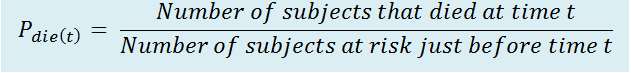

a) Probabilidad de que una persona muera en t = 0:

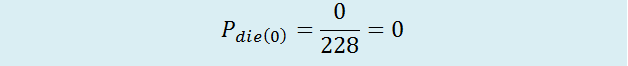

b) Probabilidad de que una persona muera en t = 5:

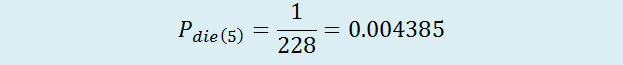

c) Probabilidad de que una persona muera en t = 11:

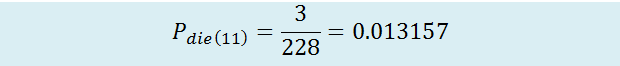

#### Densidad Acumulada:

La fórmula de la densidad acumulativa:

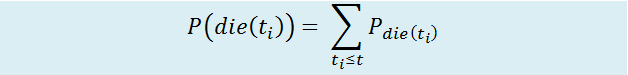

Encuentre la densidad acumulada:

d) Densidad acumulada en t = 0:

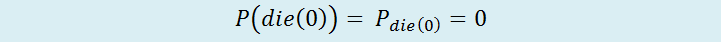

e) Densidad acumulada en t = 5:

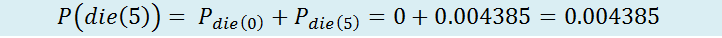

f) Densidad acumulada en t = 11:

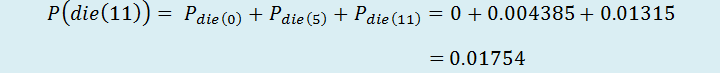

## Cáculo de la densidad acumulada mediante el Método Kaplan Meier

In [ ]:
#Probabaility of a subject dying:
#p(1022) = p(0) +......+p(1022)
kmf.cumulative_density_

##### Trace el gráfico de densidad acumulada:

In [ ]:
#Plot the cumulative density graph:
kmf.plot_cumulative_density()
plt.title("Cumulative Density Plot")
plt.xlabel("Number of days")
plt.ylabel("Probability of person's death")

Observe que, a medida que aumenta el número de días de supervivencia, aumenta la probabilidad de que una persona muera.

#### La densidad acumulada con intervalo de confianza:

In [ ]:
#Cumulative density with confidence interval:
kmf.confidence_interval_cumulative_density_

#### Gráfico de densidad acumulada con intervalo de confianza:

In [ ]:
#Plot cumulative density with confidence interval:
confidence_cumulative_density = kmf.confidence_interval_cumulative_density_
plt.plot(kmf.confidence_interval_cumulative_density_["KM_estimate_lower_0.95"],label="Lower")
plt.plot(kmf.confidence_interval_cumulative_density_["KM_estimate_upper_0.95"],label="Upper")
plt.title("Cumulative Density With Confidence Interval")
plt.xlabel("Number of days")
plt.ylabel("Cumulative Density")
plt.legend()

##### Obtenga la densidad acumulativa para un día en particular:

In [ ]:
#Densidad acumulada con intervalo de confianza mayor al 95%
#Encontramos en el punto t=200
kmf.cumulative_density_at_times(times=200)

#### El tiempo medio hasta que ocurra un evento
Podemos obtener la cantidad de tiempo restante del tiempo medio de supervivencia. Este tiempo irá variando a medida que pasa el tiempo, ya que se irá recalculando a medida que mueran o se recuperen personas.


In [ ]:
kmf.conditional_time_to_event_

### Gráfico de la mediana del tiempo transcurrido hasta el evento:

In [ ]:
#Conditional median time left for event:
median_time_to_event = kmf.conditional_time_to_event_
plt.plot(median_time_to_event,label="Median Time left")
plt.title("Medain time to event")
plt.xlabel("Total days")
plt.ylabel("Conditional median time to event")
plt.legend()

Se puede observar que la gráfica no es linealmente decreciente, ya que se irá recalculando el tiempo medio de supervivencia a medida que sucenden eventos (muertes, recuperaciones, censuras ...)

## Estimación de las tasas de riesgo mediante Nelson-Aalen
### Función de peligro H (t):
Hasta ahora, discutimos la función de supervivencia de Kaplan-Meier. Usando eso, podemos obtener la probabilidad de que el evento de interés (muerte en nuestro caso) no ocurra en ese momento. Las funciones de supervivencia son una excelente manera de resumir y visualizar el conjunto de datos de supervivencia; sin embargo, no es la única forma. Podemos visualizar la información agregada sobre supervivencia utilizando la función de riesgo de Nelson-Aalen h (t). La función de riesgo h (t) nos da la probabilidad de que un sujeto bajo observación en el momento t tenga un evento de interés (muerte) en ese momento. Para obtener la información sobre la función de riesgo, no podemos transformar el estimador de Kaplan-Meier. Para eso, existe un estimador no paramétrico adecuado de la función de riesgo acumulativo :

Función de riesgo acumulativo:

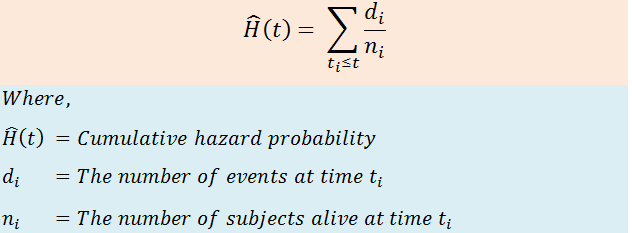

##### Importe las bibliotecas necesarias:

In [ ]:
#Hazard function:
from lifelines import NelsonAalenFitter

#Crea un objeto de Nelson-Aalen-Fitter:
naf = NelsonAalenFitter()

#Ajuste de los datos:
naf.fit(data["time"], event_observed=data["dead"])

##### Encontrar el peligro acumulativo:
Aquí usaremos la tabla de eventos generada en la parte anterior para comprender cómo funciona realmente la función de peligro.

In [ ]:
kmf.event_table

Aquí está la fórmula para encontrar la probabilidad de peligro no acumulativa en un momento específico:

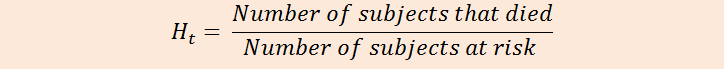

a) Hallar la probabilidad de peligro en t = 0:

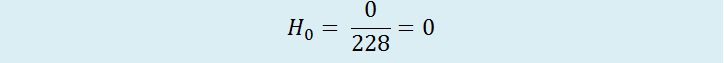

b) Encontrar la probabilidad de peligro en t = 5:

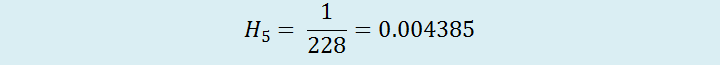

c) Encontrar la probabilidad de peligro en t = 11:

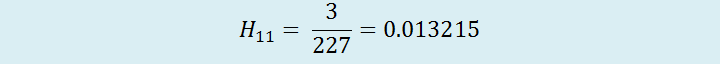

d) Encontrar la probabilidad de peligro acumulada en t = 0:

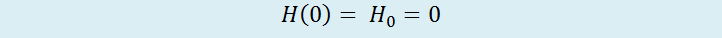

e) Hallar la probabilidad de peligro acumulada en t = 5:

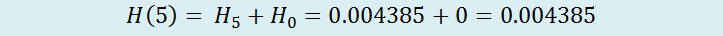

f) Encontrar la probabilidad de peligro acumulada en t = 11:

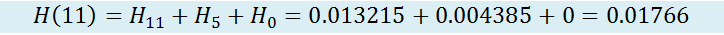

In [ ]:
#Print the cumulative hazard:
naf.cumulative_hazard_

##### Trace el gráfico de peligro acumulativo

In [ ]:
#Plot the cumulative hazard grpah:
naf.plot_cumulative_hazard()
plt.title("Cumulative Probability for Event of Interest")
plt.xlabel("Number of days")
plt.ylabel("Cumulative Probability of person's death")

El peligro acumulativo tiene una comprensión menos clara que las funciones de supervivencia, pero las funciones de peligro se basan en técnicas de análisis de supervivencia más avanzadas.

##### Predecir un valor

In [ ]:
#We can predict the value at a certain point :
print("Time = 500 days: ",naf.predict(500))
print("Time = 1022 days: ",naf.predict(1022))

##### Probabilidad de peligro acumulada con intervalo de confianza

In [ ]:
#Cumulative hazard with confidence interval:
naf.confidence_interval_

##### Gráfico de probabilidad de peligro acumulada con intervalo de confianza

In [ ]:
#Plot cumulative hazard with confidence interval:
confidence_interval = naf.confidence_interval_
plt.plot(confidence_interval["NA_estimate_lower_0.95"],label="Lower")
plt.plot(confidence_interval["NA_estimate_upper_0.95"],label="Upper")
plt.title("Cumulative hazard With Confidence Interval")
plt.xlabel("Number of days")
plt.ylabel("Cumulative hazard")
plt.legend()

##### Peligro acumulativo frente a densidad acumulada

In [ ]:
#Plot the cumulative_hazard and cumulative density:
kmf.plot_cumulative_density(label="Cumulative Hazard")
naf.plot_cumulative_hazard(label="Cumulative Density")
plt.xlabel("Number of Days")